In [1]:
import os
import time
import datetime
import numpy as np
import pandas as pd
# For seeing all columns
pd.set_option('max_columns', None)

from scipy.stats import reciprocal

# For data-visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML model classes
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC, NuSVC

# For making pipelines
from sklearn.pipeline import make_pipeline

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# For model explainability
#import eli5
import shap
from xgboost import plot_importance

# For cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# For checking accuracy
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

# For feature scaling
from sklearn.preprocessing import StandardScaler

# For replication of results
np.random.seed(2021)

# Check whether machine has GPU
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
par_dir = r"C:\Users\smitr\Desktop\FinPython\data\nifty50"
file_name = "SBIN.csv"
file_path_sbi = os.path.join(par_dir, file_name)

par_dir_nifty = r"C:\Users\smitr\Desktop\FinPython\data"
file_name = "NIFTY_17Sep07_09Nov20.csv"
file_path_niftySpot = os.path.join(par_dir_nifty, file_name)

file_name = "NiftyBank_17Sep07_06Nov20.csv"
file_path_bankNftySpot = os.path.join(par_dir_nifty, file_name)

par_dir_int_indices = os.path.join(par_dir_nifty, "International Indices")
file_path_nikkei = os.path.join(par_dir_int_indices, "Nikkei225_04Jan80_08Jan21.csv")

#par_dir_int_indices = os.path.join(par_dir_nifty, "International Indices")
#file_path_hngSng = os.path.join(par_dir_int_indices, "HangSeng_31Dec86_08Jan21.csv")

df = pd.read_csv(file_path_sbi)
df.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2007-12-03,221.341003,217.755005,219.839996,219.345001,10122532.0,65.268867
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471
2,2007-12-05,226.350998,218.080994,218.518997,224.983002,12728929.0,66.946533


## Feature extraction :-

In [3]:
def target_transform(x):
    if x > 0:
        return 1
    else:
        return 0

def get_month_day(date):
    return int(date.split("-")[2])    

def get_month(date):
    return int(date.split("-")[1])

In [4]:
df["return"] = df["Open"] - df["Close"]
df["ret_pct"] = (df["Open"] - df["Close"]) / df["Open"]
df["Target"] = df["return"].apply(target_transform)
df.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,return,ret_pct,Target
0,2007-12-03,221.341003,217.755005,219.839996,219.345001,10122532.0,65.268867,0.494995,0.002252,1
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471,1.151001,0.005242,1
2,2007-12-05,226.350998,218.080994,218.518997,224.983002,12728929.0,66.946533,-6.464005,-0.029581,0


In [5]:
# Gap up/down of stock price gives a view about current sentiment regarding stock
df["Stock_gap"] = df["Open"] - df["Close"].shift(periods=1)
#df["prev3_Target"] = df["Target"].shift(periods=3)

# Using day of month as a feature
df["MonthDay"] = df["Date"].apply(get_month_day)

# Using month as a feature
df["Month"] = df["Date"].apply(get_month)

# Nifty spot gap up/down
df_nfty_spot = pd.read_csv(file_path_niftySpot)
df_nfty_spot["NiftySpot_gap"] = df_nfty_spot["Open"] - df_nfty_spot["Close"].shift(periods=1)

# Sector-wise gap up/down
df_bankNfty_spot = pd.read_csv(file_path_bankNftySpot)
df_bankNfty_spot["BankNiftySpot_gap"] = df_bankNfty_spot["Open"] - df_bankNfty_spot["Close"].shift(periods=1)

# Nikkei gap up/down
df_nikkei = pd.read_csv(file_path_nikkei)
df_nikkei["Nikkei_gap"] = df_nikkei["Open"] - df_nikkei["Close"].shift(periods=1)

# Hang Seng gap up/down
#df_hngSng = pd.read_csv(file_path_hngSng)
#df_hngSng["HangSeng_gap"] = df_hngSng["Open"] - df_hngSng["Close"].shift(periods=1)

# Merging data frames
df = pd.merge(df, df_nfty_spot[["Date", "NiftySpot_gap"]], on="Date")
df = pd.merge(df, df_bankNfty_spot[["Date", "BankNiftySpot_gap"]], on="Date")
df = pd.merge(df, df_nikkei[["Date", "Nikkei_gap"]], on="Date")
#df = pd.merge(df, df_hngSng[["Date", "HangSeng_gap"]], on="Date")

# Dropping rows with NaN values
df.dropna(inplace=True)

df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,return,ret_pct,Target,Stock_gap,MonthDay,Month,NiftySpot_gap,BankNiftySpot_gap,Nikkei_gap
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471,1.151001,0.005242,1,0.212006,4,12,5.200195,6.600586,-15.080078
2,2007-12-05,226.350998,218.080994,218.518997,224.983002,12728929.0,66.946533,-6.464005,-0.029581,0,0.112991,5,12,3.549805,6.350586,-61.240234
3,2007-12-06,229.917007,224.464005,226.445007,226.024994,10837323.0,67.256592,0.420013,0.001855,1,1.462006,6,12,1.049805,63.500000,173.520508
4,2007-12-07,231.889008,225.501007,228.785004,229.822998,10566995.0,68.386726,-1.037994,-0.004537,0,2.760010,7,12,8.899902,57.699219,118.160156
5,2007-12-10,231.960007,227.860001,229.841995,228.893005,5373405.0,68.110001,0.948990,0.004129,1,0.018997,10,12,-0.299805,4.100586,50.959961


## Train-test split :-

In [6]:
train_size = int(len(df)*0.8)
print(train_size)

train = df[:train_size]
test = df.copy()[train_size:]

train.head(2)

2167


,Date,High,Low,Open,Close,Volume,Adj Close,return,ret_pct,Target,Stock_gap,MonthDay,Month,NiftySpot_gap,BankNiftySpot_gap,Nikkei_gap
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471,1.151001,0.005242,1,0.212006,4,12,5.200195,6.600586,-15.080078
2,2007-12-05,226.350998,218.080994,218.518997,224.983002,12728929.0,66.946533,-6.464005,-0.029581,0,0.112991,5,12,3.549805,6.350586,-61.240234


In [7]:
# Variable = Key, Target prob = Value in dictionary
mnthDay_encodings = train.groupby(['MonthDay'])['Target'].mean().to_dict() 
train['MonthDay_enc'] =  train['MonthDay'].map(mnthDay_encodings) 
test['MonthDay_enc'] =  test['MonthDay'].map(mnthDay_encodings) 

month_encodings = train.groupby(['Month'])['Target'].mean().to_dict() 
train['Month_enc'] =  train['Month'].map(month_encodings) 
test['Month_enc'] =  test['Month'].map(month_encodings) 

train.head(3)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,High,Low,Open,Close,Volume,Adj Close,return,ret_pct,Target,Stock_gap,MonthDay,Month,NiftySpot_gap,BankNiftySpot_gap,Nikkei_gap,MonthDay_enc,Month_enc
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471,1.151001,0.005242,1,0.212006,4,12,5.200195,6.600586,-15.080078,0.492958,0.575419
2,2007-12-05,226.350998,218.080994,218.518997,224.983002,12728929.0,66.946533,-6.464005,-0.029581,0,0.112991,5,12,3.549805,6.350586,-61.240234,0.472222,0.575419
3,2007-12-06,229.917007,224.464005,226.445007,226.024994,10837323.0,67.256592,0.420013,0.001855,1,1.462006,6,12,1.049805,63.500000,173.520508,0.594203,0.575419


In [20]:
print(mnthDay_encodings)
print(month_encodings)

{1: 0.43333333333333335, 2: 0.5645161290322581, 3: 0.5, 4: 0.49295774647887325, 5: 0.4722222222222222, 6: 0.5942028985507246, 7: 0.5443037974683544, 8: 0.5466666666666666, 9: 0.527027027027027, 10: 0.5657894736842105, 11: 0.5492957746478874, 12: 0.6351351351351351, 13: 0.547945205479452, 14: 0.4722222222222222, 15: 0.4852941176470588, 16: 0.48717948717948717, 17: 0.589041095890411, 18: 0.5064935064935064, 19: 0.6578947368421053, 20: 0.5571428571428572, 21: 0.5, 22: 0.52, 23: 0.47540983606557374, 24: 0.5373134328358209, 25: 0.56, 26: 0.6231884057971014, 27: 0.5714285714285714, 28: 0.5526315789473685, 29: 0.5714285714285714, 30: 0.5074626865671642, 31: 0.5135135135135135}
{1: 0.5792349726775956, 2: 0.582010582010582, 3: 0.5128205128205128, 4: 0.5371428571428571, 5: 0.5300546448087432, 6: 0.5141509433962265, 7: 0.4869109947643979, 8: 0.6054054054054054, 9: 0.4662576687116564, 10: 0.5515151515151515, 11: 0.5238095238095238, 12: 0.5754189944134078}


In [33]:
not_feats = ["Date","High","Low","Open","Close","Volume","Adj Close",
             "return","ret_pct","Target","MonthDay","Month"]
feature_columns = list(set(train.columns.values) - set(not_feats))

X_train, X_test = train[feature_columns], test[feature_columns]
y_train, y_test = train.Target.values, test.Target.values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2167, 6) (2167,)
(542, 6) (542,)


In [34]:
X_train.head(2)

,NiftySpot_gap,Month_enc,MonthDay_enc,Nikkei_gap,BankNiftySpot_gap,Stock_gap
1,5.200195,0.575419,0.492958,-15.080078,6.600586,0.212006
2,3.549805,0.575419,0.472222,-61.240234,6.350586,0.112991


## Utility functions for checking model accuracy :-

In [10]:
seed = 2021

def get_highThresh_acc(y_pred_probs, y_test, thresh_prob=0.65):
    
    cnt, corr_predicts = 0, 0
    for i in range(len(y_test)):
        if y_pred_probs[i] > thresh_prob:    # Predict 1 (up move)
            cnt += 1
            if y_test[i] == 1:
                corr_predicts += 1
            else: pass
        elif y_pred_probs[i] < 1.0 - thresh_prob:    # Predict 0 (down move)
            cnt += 1
            if y_test[i] == 0:
                corr_predicts += 1
            else: pass
        else: continue
            
    print("Prediction accuracy : {}".format(corr_predicts/cnt))
    print("Percentage of datapoints predicted : {}".format(cnt/len(y_test)))
    print("No.of datapoints predicted : {}, Total datapoints : {}".format(cnt, len(y_test)))

    return

def get_highThresh_acc_lr(y_pred_probs, y_test, thresh_prob=0.65):
    
    cnt, corr_predicts = 0, 0
    for i in range(len(y_test)):
        
        if max(y_pred_probs[i]) > thresh_prob:
            cnt += 1
            if np.argmax(y_pred_probs[i]) == y_test[i]:
                corr_predicts += 1
                
    print("Accuracy with {} threshold : {}".format(thresh_prob, corr_predicts/cnt))
    print("Percentage of datapoints predicted : {}".format(cnt/len(y_test)))
    print("No.of datapoints predicted : {}, Total datapoints : {}".format(cnt, len(y_test)))

    return      

## Applying ML models on data :-
<br>

### i) Logistic Regression

In [37]:
def loguniform(low=0, high=1, size=100):
    return reciprocal(np.exp(low), np.exp(high)).rvs(size)

# Create model
lr = LogisticRegression(random_state=seed)

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# Define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs','liblinear']    
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

# Define search
lr_search = RandomizedSearchCV(lr, space, n_iter=100, scoring='accuracy', 
                               n_jobs=-1, cv=cv, random_state=seed)

# Execute search
lr_result = lr_search.fit(X_train, y_train)

# Summarize result
print('Best Score: {}'.format(lr_result.best_score_))
print('Best Hyperparameters: {}'.format(lr_result.best_params_))

#y_pred_probabs = lr.predict_proba(X_test)
#get_highThresh_acc_lr(y_pred_probabs, y_test, 0.68)

One or more of the test scores are non-finite: [       nan 0.55807092 0.55807092 0.55807092        nan        nan
        nan        nan        nan 0.55621978 0.55621978        nan
 0.55807092        nan        nan        nan 0.55807092 0.55807092
 0.55576037        nan 0.55884252        nan 0.55575966        nan
        nan        nan        nan 0.55575895 0.55575895 0.55575895
 0.55621978        nan        nan        nan 0.55807092 0.55807092
        nan        nan 0.55575895 0.55807092        nan 0.55575895
        nan 0.55575895        nan        nan 0.55560463        nan
        nan        nan        nan        nan        nan 0.55575895
        nan        nan        nan 0.55575895        nan        nan
 0.55575895 0.55621978        nan 0.55575895 0.55575895 0.55545102
 0.55807092        nan 0.55575895 0.55575895        nan        nan
 0.55807092 0.55807092        nan        nan 0.55714926        nan
 0.55591327 0.55575966 0.55807092        nan        nan        nan
        nan 0.5

Best Score: 0.55884252147693
Best Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 3036.6223939178935}


In [38]:
# Setting best hyperparameters 
lr.set_params(**lr_result.best_params_)
lr.get_params("model")

{'C': 3036.6223939178935,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 2021,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [39]:
# Fitting the model after initializing with best hyperparameters
lr.fit(X_train, y_train)

# Applying model on test set
y_pred = lr.predict(X_test)
print("Test accuracy : {}".format(accuracy_score(y_true=y_test,y_pred=y_pred)))

Test accuracy : 0.518450184501845


In [36]:
lr.coef_

array([[-2.61130674e-03,  2.03136566e+00,  4.59746036e+00,
         7.45858135e-04, -6.88412048e-04,  9.50372531e-02]])

In [55]:
eli5.show_weights(lr, feature_names = train[feature_columns].columns.tolist())

Weight?,Feature
+1.941,MonthDay_enc
+1.299,Month_enc
+0.095,Stock_gap
+0.001,Nikkei_gap
-0.001,BankNiftySpot_gap
-0.003,NiftySpot_gap
-1.599,<BIAS>


**Month day encodings & month encoding features are most important. Thus, it is pretty clear that the model isnt making a clever prediction.**

### ii) K-Nearest Neighbours :-

In [40]:
# Create model
neigh = KNeighborsClassifier(n_neighbors=5)
# Fit the model to data
neigh.fit(X_train, y_train)
print("Accuracy :- {}".format(neigh.score(X_test, y_test)))

Accuracy :- 0.5239852398523985


### iii) Random Forest :-

In [19]:
# Prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=seed, shuffle=True)

# Create Random Forest model
rfc = RandomForestClassifier(n_estimators=10,
                              random_state=seed)
# Evaluate model
scores = cross_val_score(rfc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# Report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

#rfc.score(X_test, y_test)

NameError: name 'KFold' is not defined

In [ ]:
import shap
# Need to load JS viz in notebook
shap.initjs()

# Create object that can calculate shap values
rf_explainer = shap.TreeExplainer(rfc)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)

shap.force_plot(shap_values[1], X_test)

### iv) SVMs :-

In [22]:
nu_svm_params = {"nu":0.1,
                 "random_state":2021}

skl = StandardScaler()
X_train = skl.fit_transform(X_train)

nu_svm_clf =  NuSVC(**nu_svm_params)
nu_svm_clf.fit(X_train, y_train)

X_test = skl.transform(X_test)
nu_svm_clf.score(X_test, y_test)

0.5350553505535055

In [27]:
rbf_svm = SVC(random_state=2021,
             kernel="rbf")
rbf_svm.fit(X_train, y_train)

X_test = skl.transform(X_test)
rbf_svm.score(X_test, y_test)

0.5350553505535055

### iv) XGBoost :-

In [42]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify XGBoost parameters
params = {
    'max_depth': 6,  # the maximum depth of each tree
    'eta': 0.2,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}  # the number of classes that exist in this datset

# No.of training iterations
num_iters = 50  

# Create & Fit model
xg_boost = xgb.train(params, dtrain, num_iters)

# Predict classes for test set
preds = xg_boost.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

# Print test accuracy
print("Accuracy with 0.5 threshold :- {}".format(precision_score(y_test, best_preds, average='macro')))
get_highThresh_acc_lr(preds, y_test, thresh_prob=0.9)

Accuracy with 0.5 threshold :- 0.5630144566645916
Accuracy with 0.9 threshold : 0.6666666666666666
Percentage of datapoints predicted : 0.033210332103321034
No.of datapoints predicted : 18, Total datapoints : 542


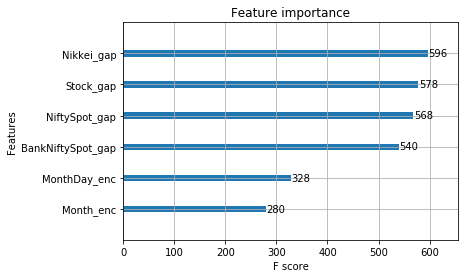

In [53]:
# plot feature importance
plot_importance(xg_boost)
plt.show()

**Observation :-** From the above plot its clear that the **opening gaps for a day get the most importance**. This shows that a a day's movement is more dependent on that day's opening sentiment rather than historic monthly or date wise sentiments. Now this is a bit **clever**.

In [41]:
#import XGBoost classifier and accuracy
from xgboost.sklearn import XGBClassifier

params = {'learning_rate':0.03, 
          'n_estimators':810,    # Number of iterations of boosting
          'max_depth':6,     # Max depth of each tree
          'verbosity':0,     # Silent, i.e, print no messages while training
          'n_jobs':-1}       # Use all CPU cores

#instantiate model and train
xgb_clf = XGBClassifier(**params)
xgb_clf.fit(X_train, y_train)

# make predictions for test set
y_pred = xgb_clf.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 52.95%


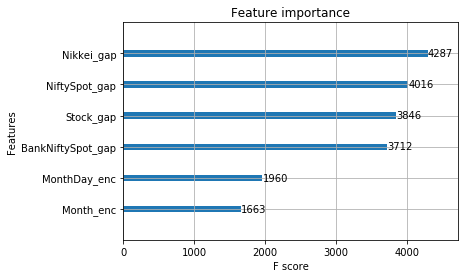

In [42]:
# plot feature importance
plot_importance(xgb_clf)
plt.show()

### v) Neural Network :-

In [61]:
fcnn = Sequential()
fcnn.add(Dense(4, input_dim=6, activation="relu"))
fcnn.add(Dense(2, activation="relu"))
fcnn.add(Dense(1, activation="sigmoid"))

fcnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [62]:
# Compiling the model
fcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Defining callbacks
filepath="SBIN_move_predictor_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Scaling the data for better model fit
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Fitting the model
fcnn.fit(X_train, y_train, epochs=30, 
         batch_size=16, validation_split=0.15,
         callbacks=callbacks_list)

Train on 1841 samples, validate on 326 samples
Epoch 1/30
1841/1841 [==============================] - ETA: 5:06 - loss: 0.7365 - acc: 0.562 - ETA: 36s - loss: 0.7684 - acc: 0.500 - ETA: 11s - loss: 0.7819 - acc: 0.47 - ETA: 5s - loss: 0.7714 - acc: 0.4703 - ETA: 2s - loss: 0.7533 - acc: 0.485 - ETA: 1s - loss: 0.7511 - acc: 0.474 - ETA: 0s - loss: 0.7524 - acc: 0.468 - ETA: 0s - loss: 0.7462 - acc: 0.470 - 3s 2ms/step - loss: 0.7448 - acc: 0.4699 - val_loss: 0.7371 - val_acc: 0.4325


Can save best model only with val_accuracy available, skipping.


Epoch 2/30
1841/1841 [==============================] - ETA: 0s - loss: 0.7171 - acc: 0.375 - ETA: 0s - loss: 0.7187 - acc: 0.486 - ETA: 0s - loss: 0.7295 - acc: 0.475 - ETA: 0s - loss: 0.7276 - acc: 0.476 - ETA: 0s - loss: 0.7246 - acc: 0.475 - ETA: 0s - loss: 0.7204 - acc: 0.481 - ETA: 0s - loss: 0.7186 - acc: 0.480 - 0s 210us/step - loss: 0.7161 - acc: 0.4840 - val_loss: 0.7136 - val_acc: 0.4540
Epoch 3/30
1841/1841 [==============================] - ETA: 0s - loss: 0.7244 - acc: 0.312 - ETA: 0s - loss: 0.7070 - acc: 0.545 - ETA: 0s - loss: 0.7150 - acc: 0.510 - ETA: 0s - loss: 0.7105 - acc: 0.494 - ETA: 0s - loss: 0.7069 - acc: 0.492 - ETA: 0s - loss: 0.7073 - acc: 0.488 - ETA: 0s - loss: 0.7075 - acc: 0.485 - ETA: 0s - loss: 0.7062 - acc: 0.489 - 0s 216us/step - loss: 0.7059 - acc: 0.4916 - val_loss: 0.7023 - val_acc: 0.4908
Epoch 4/30
1841/1841 [==============================] - ETA: 0s - loss: 0.6941 - acc: 0.437 - ETA: 0s - loss: 0.6980 - acc: 0.525 - ETA: 0s - loss: 0.7096 - a

Epoch 21/30
1841/1841 [==============================] - ETA: 0s - loss: 0.6992 - acc: 0.437 - ETA: 0s - loss: 0.6798 - acc: 0.595 - ETA: 0s - loss: 0.6884 - acc: 0.553 - ETA: 0s - loss: 0.6893 - acc: 0.552 - ETA: 0s - loss: 0.6892 - acc: 0.546 - ETA: 0s - loss: 0.6884 - acc: 0.551 - ETA: 0s - loss: 0.6891 - acc: 0.545 - 0s 197us/step - loss: 0.6885 - acc: 0.5475 - val_loss: 0.6837 - val_acc: 0.5859
Epoch 22/30
1841/1841 [==============================] - ETA: 0s - loss: 0.6720 - acc: 0.625 - ETA: 0s - loss: 0.6861 - acc: 0.562 - ETA: 0s - loss: 0.6900 - acc: 0.537 - ETA: 0s - loss: 0.6898 - acc: 0.544 - ETA: 0s - loss: 0.6879 - acc: 0.551 - ETA: 0s - loss: 0.6885 - acc: 0.547 - ETA: 0s - loss: 0.6889 - acc: 0.544 - 0s 197us/step - loss: 0.6882 - acc: 0.5464 - val_loss: 0.6834 - val_acc: 0.5828
Epoch 23/30
1841/1841 [==============================] - ETA: 0s - loss: 0.6410 - acc: 0.875 - ETA: 0s - loss: 0.6888 - acc: 0.546 - ETA: 0s - loss: 0.6854 - acc: 0.560 - ETA: 0s - loss: 0.6872 

In [63]:
def get_test_acc(y_pred, y_test):
    
    correct = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]: correct += 1
        else: pass
        
    return 100*correct/len(y_pred)


# Scaling test data
X_test = scaler.transform(X_test)

# Applying model on test data
y_pred = fcnn.predict_classes(X_test)
y_pred = np.squeeze(y_pred)

print("Test set accuracy : {}".format(get_test_acc(y_pred, y_test)))

Test set accuracy : 51.845018450184504


### Using ensembles :-

In [66]:
from sklearn.ensemble import VotingClassifier

# Creating Voting classifier
vote_clf = VotingClassifier(estimators=[('lr', lr),
                                     ('knn', neigh),
                                     ('xgb', xgb_clf)],
                         voting='hard')

# Fitting voting classifer model
vote_clf.fit(X_train,y_train)

# Applying on test set
vote_clf.score(X_test,y_test)

0.540590405904059

In [45]:
from mlxtend.classifier import StackingClassifier

meta_lr = LogisticRegression(random_state=2021)

sclf = StackingClassifier(classifiers=[lr, neigh, xgb_clf], 
                          meta_classifier=meta_lr,
                          fit_base_estimators=False)

sclf.fit(X_train, y_train)

StackingClassifier(classifiers=[LogisticRegression(C=3036.6223939178935,
                                                   random_state=2021),
                                KNeighborsClassifier(),
                                XGBClassifier(learning_rate=0.03, max_depth=6,
                                              n_estimators=810, n_jobs=-1,
                                              verbosity=0)],
                   fit_base_estimators=False,
                   meta_classifier=LogisticRegression(random_state=2021),
                   use_clones=False)

In [48]:
np.mean(y_test == sclf.predict(X_test))

0.5295202952029521